In [1]:
from analysis import *

%matplotlib inline

# Set style for all plots
sns.set_style("whitegrid")
plt.style.use('seaborn')


/var/folders/13/81m8_c8s5x3dwyxpg6hc69nw0000gn/T/ipykernel_52621/1484485703.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# 1. parallelization speedup ~ throughput (episodes/fixed time budget) ~ playing strength (win rate, Elo)

<Figure size 1500x1000 with 0 Axes>

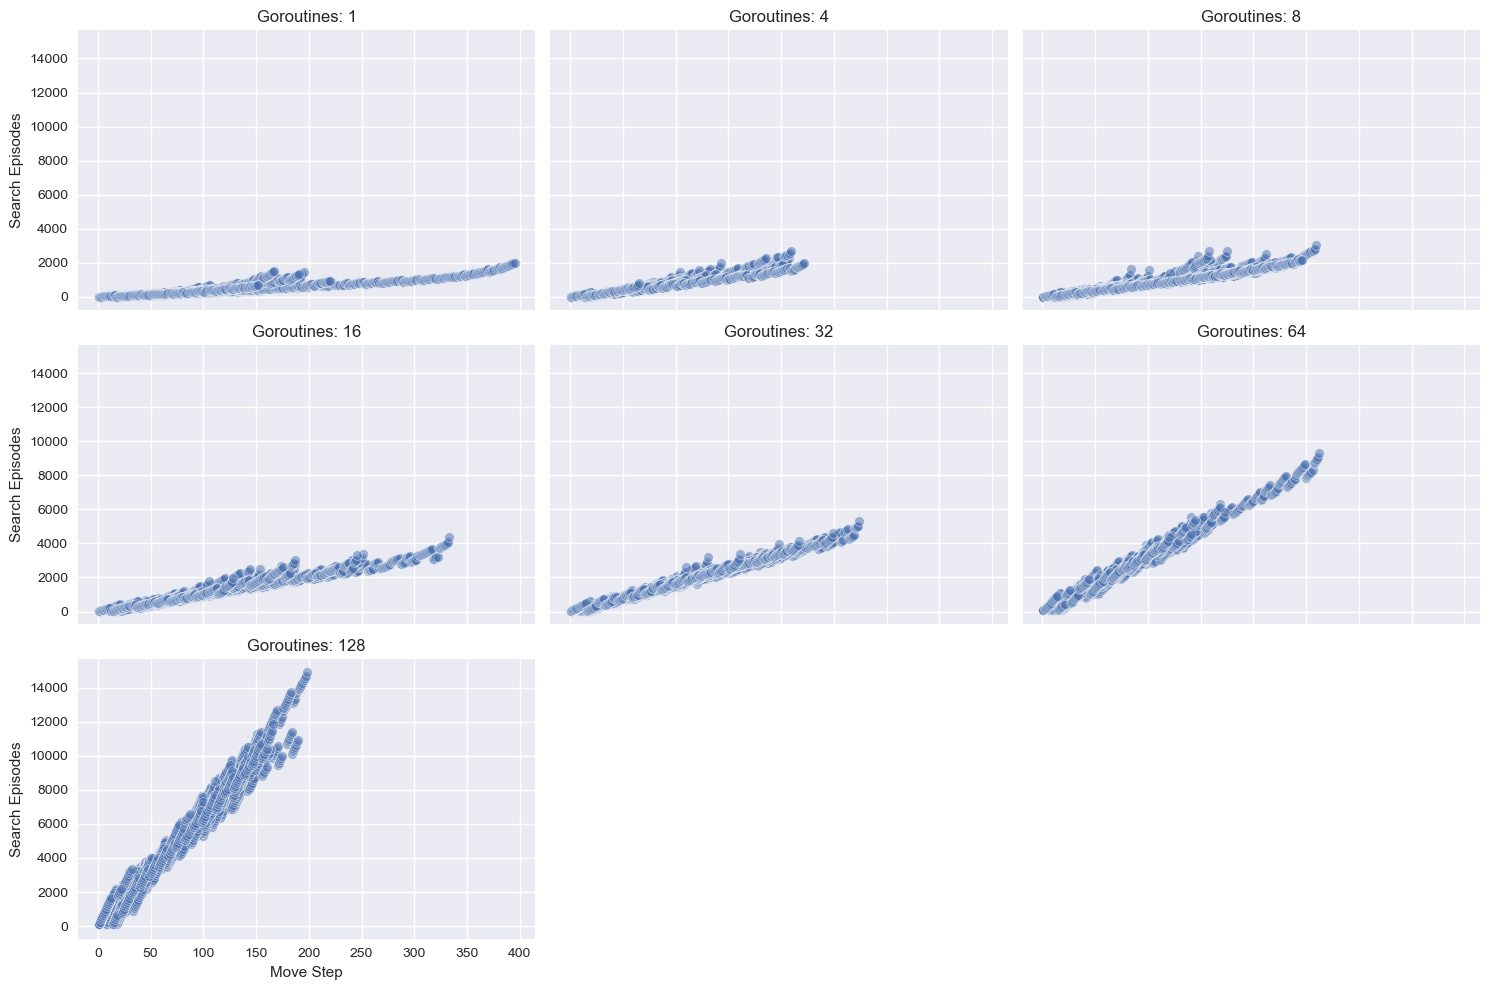

In [2]:
# Load experiment data
# TODO: use same experiment setup as strength experiment (diff concurrency levels parallel agents vs baseline)
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/parallelization_to_throughput")

# Generate plots
# TODO: smaller dot
plt = plot_episodes_by_step(move_records, agent_configs, output_dir)
plt.show()

- environment: 8-core CPU (4 performance cores + 4 efficiency cores)
- concurrency level increase (x4) -> episodes increase both earlier in game and in volume
- full playouts (no cutoff) > faster playouts/more episodes as game progresses/deeper into game

<Figure size 1500x1000 with 0 Axes>

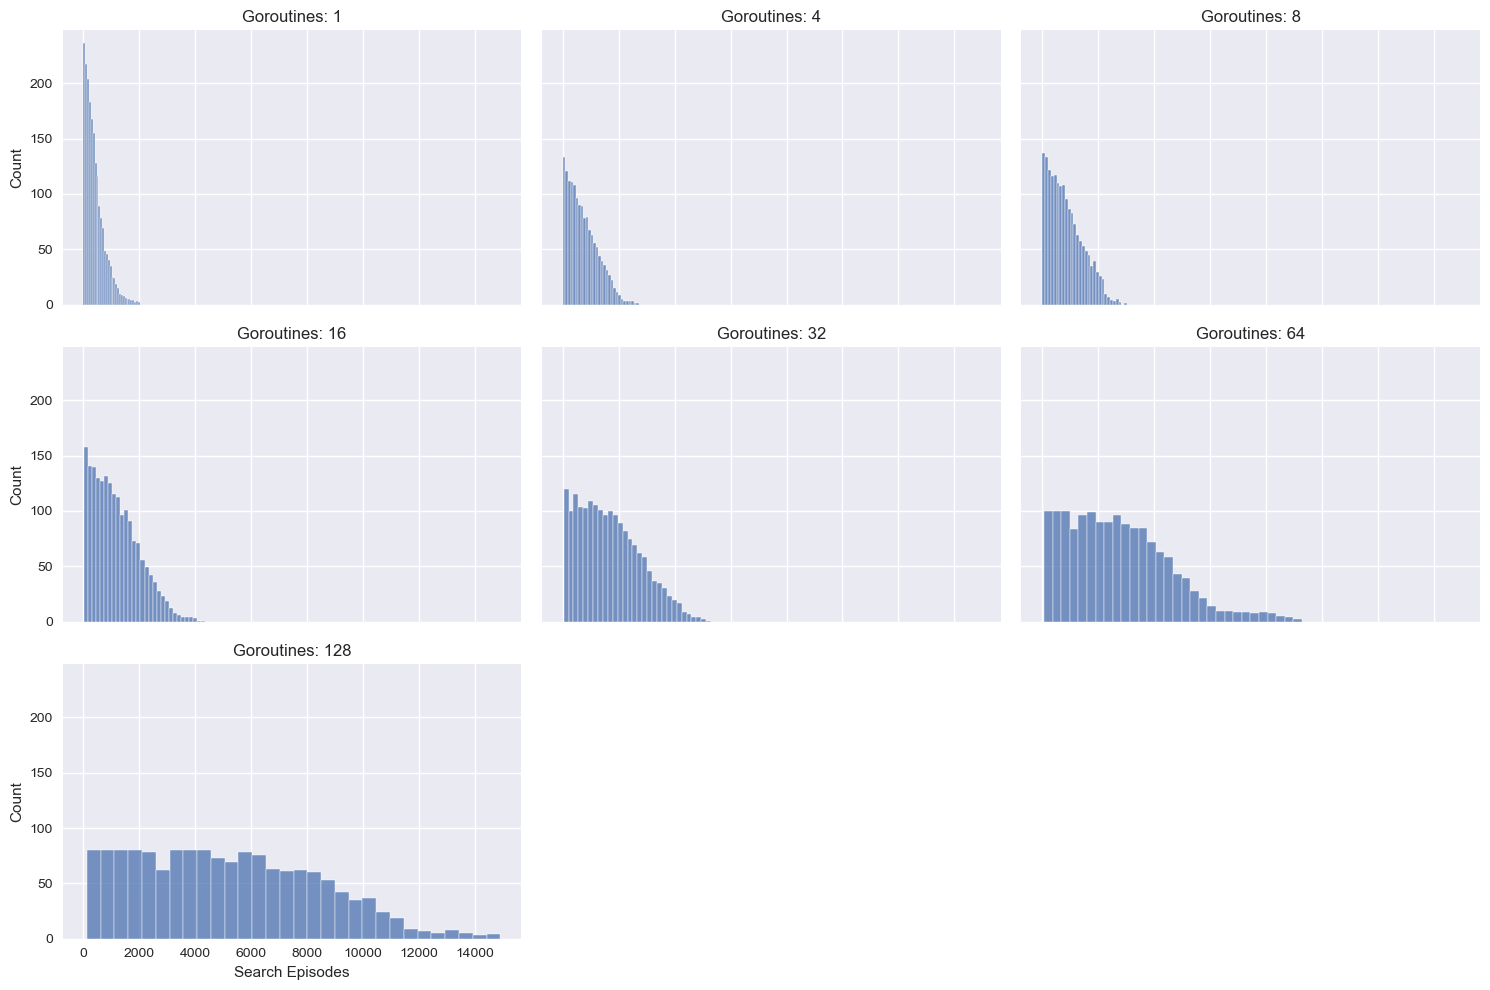

In [3]:
plt = plot_episodes_histogram(move_records, agent_configs, output_dir)
plt.show()

- all power law distribution (most searches have few episodes) > use box plot
- concurrency level increase -> more searchers with more episodes 

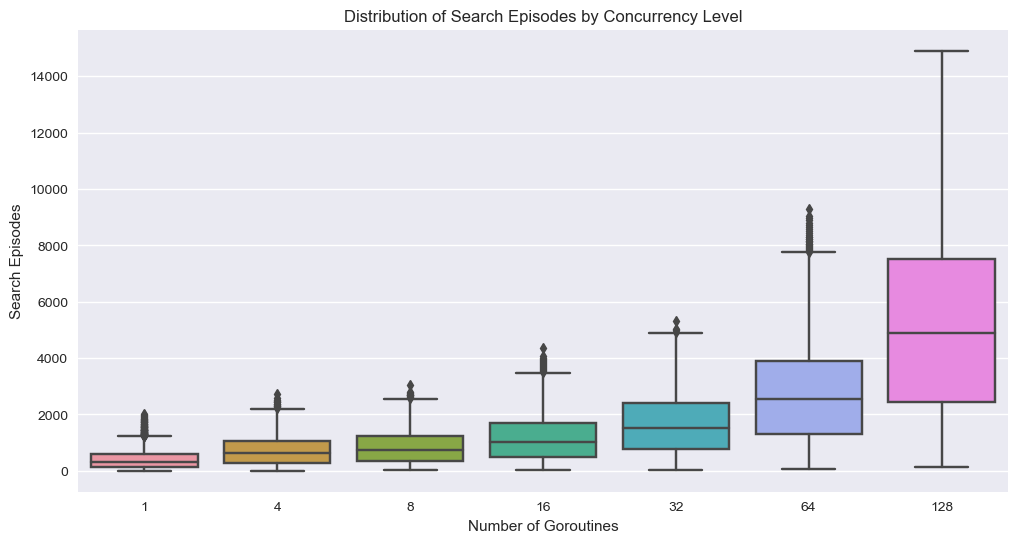


Summary Statistics by Concurrency Level:
                   mean          std  min    max
goroutines                                      
1            415.927803   353.617967    3   2018
4            723.472812   529.517543    9   2712
8            848.904433   605.810198   11   3032
16          1167.158198   822.440897   16   4360
32          1669.046179  1098.803035   32   5306
64          2750.689180  1848.535390   64   9290
128         5148.549230  3211.785041  128  14905


In [4]:
# TODO: or violin plot?
plt = plot_episodes_boxplot(move_records, agent_configs, output_dir)
plt.show()

# Print summary statistics
print("\nSummary Statistics by Concurrency Level:")
summary = move_records.groupby('goroutines')['episodes'].agg(['mean', 'std', 'min', 'max'])
print(summary)

- higher concurrency level -> more episodes
- not much diff between 4 and 8: why?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


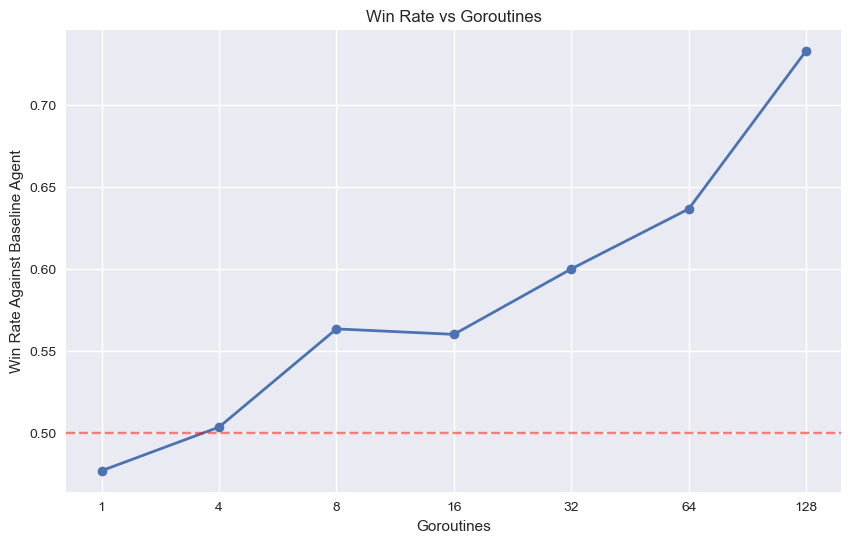


Win Rates vs Baseline Agent:
   agent2  games  wins  win_rate  id  goroutines duration  episodes  cutoff  \
0       1    300   143  0.476667   1           1     10ms         0       0   
1       2    300   151  0.503333   2           4     10ms         0       0   
2       3    300   169  0.563333   3           8     10ms         0       0   
3       4    300   168  0.560000   4          16     10ms         0       0   
4       5    300   180  0.600000   5          32     10ms         0       0   
5       6    300   191  0.636667   6          64     10ms         0       0   
6       7    300   220  0.733333   7         128     10ms         0       0   

  evaluation  
0          .  
1          .  
2          .  
3          .  
4          .  
5          .  
6          .  


In [5]:
# Load experiment data
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/parallelization_to_strength")

# Calculate and plot win rates
win_rates = calculate_win_rates(game_records, agent_configs)
# TODO: write number of games played
plt = plot_win_rates(win_rates, param_col="goroutines", output_dir=output_dir)
plt.show()

print("\nWin Rates vs Baseline Agent:")
print(win_rates)


- baseline agent vs 1-goroutine agent win rate not 0.5??
- should see steady climb in win rate as concurrency level increases
- win rate reflects relative playing strength against baseline agent 
- elo rating reflects relative playing strength against all other agents 
=> should show similar trend: higher concurrency > more episodes per time budget > greater playing strength > higher win rate & Elo rating

- don't show baseline agent rating: more games played > drags rating down to below 1-goroutine agent's (despite 0.5 win rate)
- should reflect similar trend as win rate

In [6]:
# TODO: to potentially explain irregularities in results:
# TODO: plot # of full playouts out of (vs) # of episodes per step across per matchup games, then analyze and explain 
# TODO: plot # of tree resets per step across per matchup games, then analyze and explain


# 2. cutoff depth ~ throughput (episodes/time budget) ~ playing strength (win rate)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


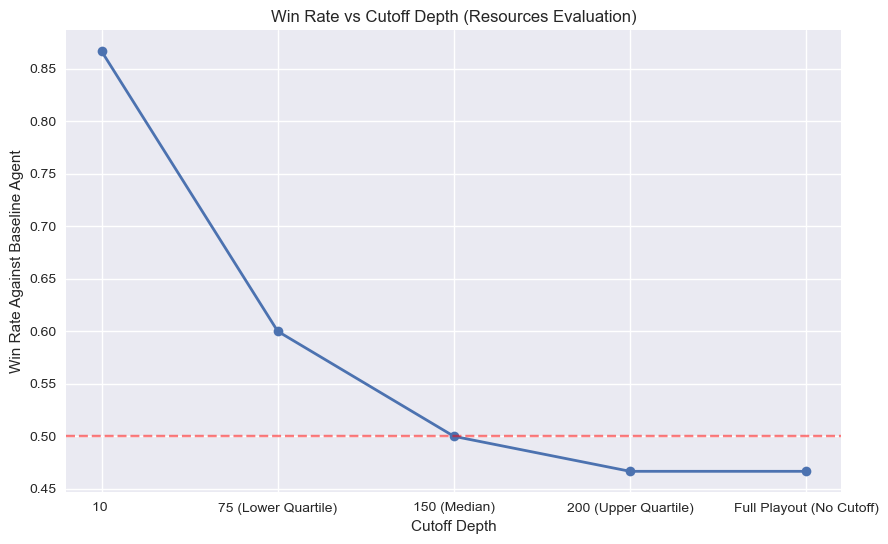

,id,agent1,agent2,starting_player,winner,start_time,end_time,duration


In [15]:
# TODO: plot game length (# of moves) vs parallel agent 
# TODO: 1) scatter plot: data points 
# TODO: 2) box plot: distribution 
# TODO: 3) line plot: mean + std

# experiment setup: pick 1 parallel agent (e.g. 16-goroutine, full playout) as new baseline, vary cutoff depth {10 or lower fence, lower quartile, median, upper quartile, full playout} while keeping other parameters constant (5 matchups), compare win rate and Elo rating 
# hypothesis: lower cutoff depth -> faster playouts -> more episodes (fixed time budget) -> discover more possible paths -> more robust stats -> more skilled agent -> higher win rate ASSUMING evaluation function estimates outcome well
# explanations: random full playout does not closely emulate real/intelligent game plays, good evaluation function may provide better outcome estimates, while faster rollouts allow more episodes within the same time budget
# future work: findings/lessons learned here (to improve playing strength) transferrable to other agents (other currency levels, after tailoring cutoff depth according to its game length distribution)
# optional: each/best agent in the cutoff depth experiment group plays 100 games against the sequential baseline, compare difference in win rates via statistical tests? (no added value)
# *ANOVA* determines whether *3 or more groups'* means are statistically significantly different/unequal (N/A). *t-test* determines whether *2 groups'* means OR *1 group's mean vs a fixed value* are statistically significantly different/larger/smaller (N/A).

# DONE: calculate and plot experiment agents' win rates
agent_configs, game_records, move_records, output_dir = load_experiment_data("data/cutoff")

cutoff_win_rates = calculate_win_rates(game_records, agent_configs)
cutoff_win_rates = process_cutoff_labels(cutoff_win_rates)
plt = plot_win_rates(
    cutoff_win_rates,
    param_col="cutoff", 
    output_dir=output_dir,
    title="Win Rate vs Cutoff Depth (Resources Evaluation)",
    xlabel="Cutoff Depth"
)
plt.show()

show_missing_data(game_records)

# TODO: calculate and plot experiment agents' throughput distribution (episodes/time budget) in the same format as concurrency experiment
# TODO: potentially 1) calculate the correlation coefficient 2) show the correlation (2 lines in one chart) between throughput and win rate

# 3. evaluation function ~ outcome estimate quality ~ playing strength (win rate, Elo?)
 

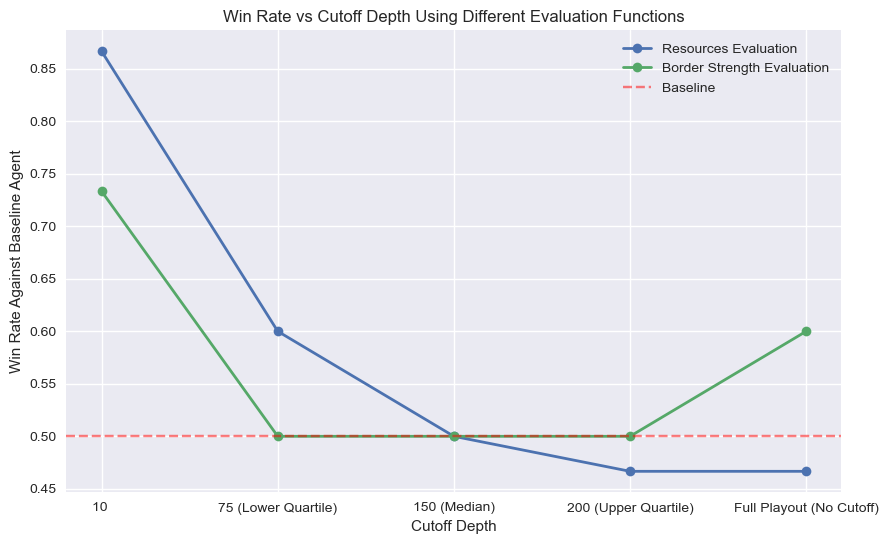

,id,agent1,agent2,starting_player,winner,start_time,end_time,duration


In [11]:
# DONE: same setup as cutoff experiment, but each experiment group agent uses border strength evaluation
# TODO: plot another line in win rate chart (5 matchups)
# hypothesis: border strength evaluation estimates outcome more accurately than resources evaluation > higher win rate at each agent > the effect may be bigger when cutoff depth is smaller 
# TODO: same setup could be extened with an agent that uses value network predictions as evaluation result to evaluate value network (future work)

agent_configs, game_records, move_records, output_dir = load_experiment_data("data/evaluation")

eval_win_rates = calculate_win_rates(game_records, agent_configs)
eval_win_rates = process_cutoff_labels(eval_win_rates)
plt = plot_combined_win_rates(
    [(cutoff_win_rates, "Resources Evaluation"), 
     (eval_win_rates, "Border Strength Evaluation")],
    param_col="cutoff",
    output_dir=output_dir,
    title="Win Rate vs Cutoff Depth Using Different Evaluation Functions",
    xlabel="Cutoff Depth"
)
plt.show()
# TODO: fix/improve border strength evaluation function (should have higher win rates)

show_missing_data(game_records)


# 4. corroborate findings > Elo ratings
setup:
- agents: 1) sequential agent, 2) 8-goroutine agent (full playout), 3) parallel agent + cutoff (resources evaluation), 4) parallel agent + cutoff + border strength evaluation
- **round-robin** 30 games between each pair (5 matchups), alternating start, random board initialization
- update Elo ratings with game outcomes in **random** order till **convergence** > relative playing strength (should show upwards trend)

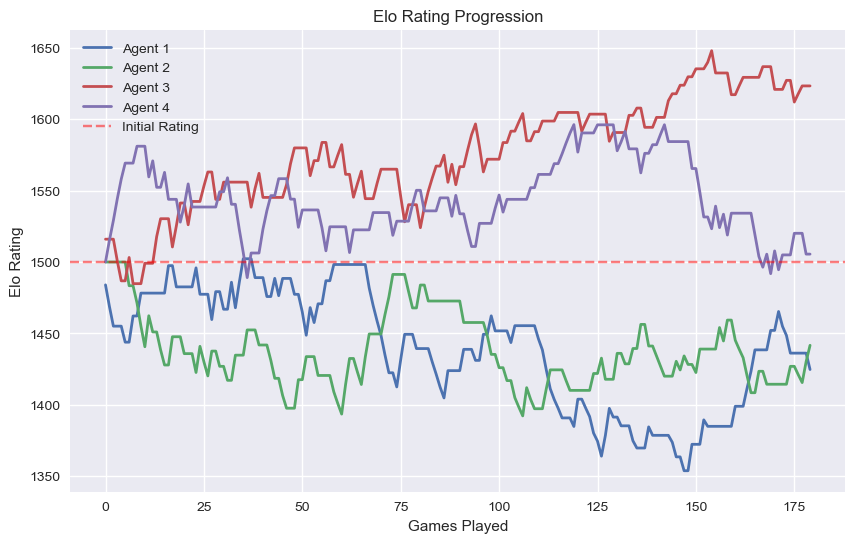

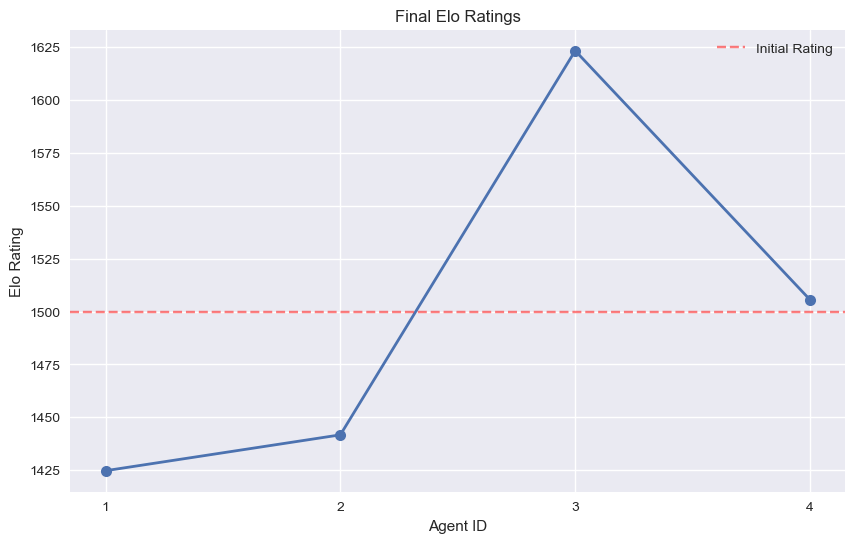

In [16]:
# TODO: calculate Elo rating updates
# TODO: plot Elo rating updatse over time, show final ratings after convergence

# TODO: establish and implement a convergence criterion 

agent_configs, game_records, move_records, output_dir = load_experiment_data("data/elo")

# TODO: apply diff K values depending on # of games each pair
# TODO: optional seed for reproducibility

# Calculate Elo ratings after each game
ratings_df = calculate_elo_updates(game_records, seed=None)

# Plot ratings progression
# TODO: check convergence
plt = plot_elo_progression(ratings_df, agent_configs, output_dir)
plt.show()

# Plot final ratings
plt = plot_final_elo_ratings(ratings_df.iloc[-1], agent_configs, output_dir)
plt.show()

- ratings should converge
- should show upwards trend across agents

Agent 1 vs Agent 2: 14 wins out of 30 games
Agent 1 vs Agent 3: 8 wins out of 30 games
Agent 1 vs Agent 4: 11 wins out of 30 games
Agent 2 vs Agent 1: 16 wins out of 30 games
Agent 2 vs Agent 3: 5 wins out of 30 games
Agent 2 vs Agent 4: 12 wins out of 30 games
Agent 3 vs Agent 1: 20 wins out of 30 games
Agent 3 vs Agent 2: 22 wins out of 30 games
Agent 3 vs Agent 4: 15 wins out of 30 games
Agent 4 vs Agent 1: 19 wins out of 30 games
Agent 4 vs Agent 2: 18 wins out of 30 games
Agent 4 vs Agent 3: 12 wins out of 30 games


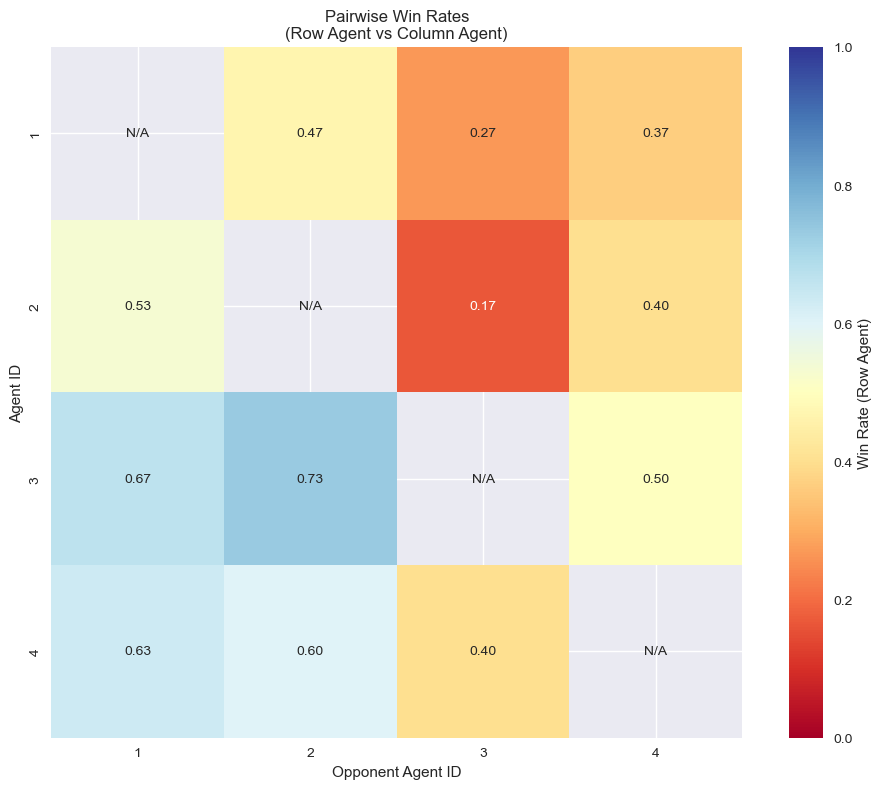

,id,agent1,agent2,starting_player,winner,start_time,end_time,duration
44,45,1,3,1,NaN,2025-01-17T17:46:50+01:00,2025-01-17T17:46:55+01:00,5.306029709s
53,54,1,3,1,NaN,2025-01-17T17:47:14+01:00,2025-01-17T17:47:19+01:00,5.297777125s
97,98,2,3,1,NaN,2025-01-17T17:48:58+01:00,2025-01-17T17:49:04+01:00,5.768359042s
117,118,2,3,1,NaN,2025-01-17T17:49:44+01:00,2025-01-17T17:49:50+01:00,5.789252584s
119,120,2,3,1,NaN,2025-01-17T17:49:52+01:00,2025-01-17T17:49:58+01:00,5.833363958s
151,152,3,4,1,NaN,2025-01-17T17:51:11+01:00,2025-01-17T17:51:17+01:00,5.263397s
169,170,3,4,1,NaN,2025-01-17T17:51:44+01:00,2025-01-17T17:51:50+01:00,5.218232916s
178,179,3,4,1,NaN,2025-01-17T17:52:02+01:00,2025-01-17T17:52:07+01:00,5.292784125s


In [14]:
# Calculate pairwise win rates
win_rates = calculate_pairwise_win_rates(game_records, agent_configs)

# Plot win rate heatmap
plt = plot_win_rate_heatmap(win_rates, agent_configs, output_dir)
plt.show()

show_missing_data(game_records)
